In [73]:
import datetime
import sys
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import itertools
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from cond_rnn import ConditionalRNN
from sklearn.preprocessing import MinMaxScaler
from collections import UserDict

import src.preprocessing
from src.functions import load_data, mape, TimeSeriesTensor, create_evaluation_df, series_to_supervised, plot_train_history, validation

np.set_printoptions(threshold=sys.maxsize)
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
DAYS_IN_YEAR = 365
HOURS_IN_DAY = 24
DAYS_OF_WEEK = ['week_1','week_2','week_3','week_4','week_5','week_6','week_7']
MINUTES_IN_HOUR = 60
SECONDS_IN_MINUTE = 60
MINUTES_IN_DAY = MINUTES_IN_HOUR * HOURS_IN_DAY

In [74]:
csv_path = '../data/ERCOT/ercot_data.csv'
df = pd.read_csv(csv_path, index_col=0)

In [75]:
df = src.preprocessing.preprocess(df, 'texas')

In [76]:
c1 = df.iloc[:,2:10]
c2 = series_to_supervised(df)
short_df = df.iloc[:,[0,1,-4,-3,-2,-1]].copy()
c1 = c1.loc[c2.index]
short_df = short_df['2012-01-07 02:00:00':]

In [77]:
print(c1.shape)
print(c2.shape)
print(short_df.shape)

(34892, 8)
(34892, 2)
(34915, 6)


In [78]:
test_df = short_df.copy()['2015':]
test_c1 = c1.copy()['2015':]
test_c2 = c2.copy()['2015':]

n_test = len(test_df)
index = len(short_df) - n_test
train_val_split = 0

train_df = short_df.copy()[:-len(test_df)]
train_c1 = c1.copy()[:-len(test_c1)]
train_c2 = c2.copy()[:-len(test_c2)]

num_features = df.shape[1]

In [79]:
y_scaler = MinMaxScaler()
y_scaler.fit(train_df[['value']])

MinMaxScaler()

In [80]:
train_c2[['value(t-24)']] = y_scaler.fit_transform(train_c2[['value(t-24)']])

In [81]:
train_c2[['value(t-168)']] = y_scaler.fit_transform(train_c2[['value(t-168)']])

In [82]:
X_scaler = MinMaxScaler()
train_df[train_df.columns] = X_scaler.fit_transform(train_df)
test_df[train_df.columns] = X_scaler.fit_transform(test_df)

In [83]:
T = 24
HORIZON = 24
tensor_structure = {'X':(range(-T+1, 1), ['value', 'Temperatures (°C)','fractional hour_sin','fractional hour_cos','day of year_sin','day of year_cos'])}
train_inputs = TimeSeriesTensor(train_df, 'value', HORIZON, tensor_structure)

In [84]:
test_inputs = TimeSeriesTensor(test_df, 'value', HORIZON, tensor_structure)

In [85]:
print(train_inputs.dataframe.shape)
print(c1.shape)
print(c2.shape)

(25967, 168)
(34892, 8)
(34892, 2)


In [86]:
train_c1 = c1.reindex(train_inputs.dataframe.index)
train_c2 = c2.reindex(train_inputs.dataframe.index)

In [87]:
test_c1 = c1.reindex(test_inputs.dataframe.index)
test_c2 = c2.reindex(test_inputs.dataframe.index)

In [88]:
print(train_inputs.dataframe.shape)
print(train_c1.shape)
print(train_c2.shape)

(25967, 168)
(25967, 8)
(25967, 2)


In [89]:
# LONGER DF
longer_df = df.copy()
#longer_df = longer_df['2012-01-07 02:00:00':]
longer_df = longer_df.merge(series_to_supervised(longer_df), how='right', left_index=True, right_index=True)

In [90]:
test_longer_df = longer_df['2015':].copy()
train_longer_df = longer_df[:-len(test_longer_df)].copy()

In [91]:
long_scaler = MinMaxScaler()
test_longer_df[test_longer_df.columns] = X_scaler.fit_transform(test_longer_df)
train_longer_df[train_longer_df.columns] = X_scaler.fit_transform(train_longer_df)

In [92]:
T = 24
HORIZON = 24
tensor_structure = {'X':(range(-T+1, 1), train_longer_df.columns)}
train_longer_inputs = TimeSeriesTensor(train_longer_df, 'value', HORIZON, tensor_structure)
test_longer_inputs = TimeSeriesTensor(test_longer_df, 'value', HORIZON, tensor_structure)

In [93]:
df_lags = short_df.merge(series_to_supervised(df), how='right', left_index=True, right_index=True)

In [94]:
test_df_lags = df_lags['2015':].copy()
train_df_lags = df_lags[:-len(test_df_lags)].copy()

In [95]:
train_Y_df_lags = train_df_lags.iloc[:,0]
test_Y_df_lags = test_df_lags.iloc[:,0]

In [96]:
X_lags_scaler = MinMaxScaler()
train_df_lags[train_df_lags.columns] = X_lags_scaler.fit_transform(train_df_lags)
test_df_lags[test_df_lags.columns] = X_lags_scaler.fit_transform(test_df_lags)

In [97]:
train_X_df_lags = train_df_lags.iloc[:,1:]
test_X_df_lags = test_df_lags.iloc[:,1:]

In [98]:
train_Y1_df_lags = train_df_lags.iloc[:,0]
test_Y1_df_lags = test_df_lags.iloc[:,0]

In [99]:
train_X_df_lags = np.asarray(train_X_df_lags).reshape((train_X_df_lags.shape[0], 1, train_X_df_lags.shape[1]))
test_X_df_lags = np.asarray(test_X_df_lags).reshape((test_X_df_lags.shape[0], 1, test_X_df_lags.shape[1]))

In [100]:
print(train_inputs.dataframe.columns.to_numpy())

[('target', 'y', 't+1') ('target', 'y', 't+2') ('target', 'y', 't+3')
 ('target', 'y', 't+4') ('target', 'y', 't+5') ('target', 'y', 't+6')
 ('target', 'y', 't+7') ('target', 'y', 't+8') ('target', 'y', 't+9')
 ('target', 'y', 't+10') ('target', 'y', 't+11') ('target', 'y', 't+12')
 ('target', 'y', 't+13') ('target', 'y', 't+14') ('target', 'y', 't+15')
 ('target', 'y', 't+16') ('target', 'y', 't+17') ('target', 'y', 't+18')
 ('target', 'y', 't+19') ('target', 'y', 't+20') ('target', 'y', 't+21')
 ('target', 'y', 't+22') ('target', 'y', 't+23') ('target', 'y', 't+24')
 ('X', 'value', 't-23') ('X', 'value', 't-22') ('X', 'value', 't-21')
 ('X', 'value', 't-20') ('X', 'value', 't-19') ('X', 'value', 't-18')
 ('X', 'value', 't-17') ('X', 'value', 't-16') ('X', 'value', 't-15')
 ('X', 'value', 't-14') ('X', 'value', 't-13') ('X', 'value', 't-12')
 ('X', 'value', 't-11') ('X', 'value', 't-10') ('X', 'value', 't-9')
 ('X', 'value', 't-8') ('X', 'value', 't-7') ('X', 'value', 't-6')
 ('X', 'v

In [120]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [122]:
val_performance = {}
performance = {}
mape_performance = {}
mse_performance = {}

baseline = Baseline(label_index = 0)

baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanSquaredError()])

predictions_B = baseline.predict(test_inputs['X'])
eval_df_B = create_evaluation_df(predictions_B.reshape(-1,24), test_inputs, HORIZON, y_scaler)

performance['Baseline'] = baseline.evaluate(test_inputs['X'],test_inputs['target'], verbose=0)
mape_performance['Baseline'] = validation(eval_df_B['prediction'], eval_df_B['actual'], 'MAPE')
mse_performance['Baseline'] = validation(eval_df_B['prediction'], eval_df_B['actual'], 'RMSE')

In [125]:
test_inputs.dataframe.head(3)

tensor                 target                                          \
feature                     y                                           
time step                 t+1       t+2       t+3       t+4       t+5   
2015-01-01 23:00:00  0.545386  0.512968  0.498526  0.489418  0.485399   
2015-01-02 00:00:00  0.512968  0.498526  0.489418  0.485399  0.496407   
2015-01-02 01:00:00  0.498526  0.489418  0.485399  0.496407  0.529108   

tensor                                                                 ...  \
feature                                                                ...   
time step                 t+6       t+7       t+8       t+9      t+10  ...   
2015-01-01 23:00:00  0.496407  0.529108  0.576000  0.615860  0.638106  ...   
2015-01-02 00:00:00  0.529108  0.576000  0.615860  0.638106  0.664575  ...   
2015-01-02 01:00:00  0.576000  0.615860  0.638106  0.664575  0.679592  ...   

tensor                            X                                     \
feature             day of year_cos                                      
time step                       t-9  t-8  t-7  t-6  t-5  t-4  t-3  t-2   
2015-01-01 23:00:00             1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2015-01-02 00:00:00             1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2015-01-02 01:00:00             1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

tensor                                   
feature                                  
time step                 t-1         t  
2015-01-01 23:00:00  1.000000  1.000000  
2015-01-02 00:00:00  1.000000  0.999992  
2015-01-02 01:00:00  0.999992  0.999992  

[3 rows x 168 columns]

In [126]:
predictions_B.reshape(-1,24)[:3]

array([[0.67129021, 0.64216349, 0.61619098, 0.6072355 , 0.60144124,
        0.60523075, 0.62185999, 0.64664452, 0.66736952, 0.68778093,
        0.70654794, 0.71285225, 0.71367988, 0.7012092 , 0.67962643,
        0.6584803 , 0.64512408, 0.65077606, 0.68008537, 0.71057203,
        0.69223109, 0.6649721 , 0.63217122, 0.58727376],
       [0.64216349, 0.61619098, 0.6072355 , 0.60144124, 0.60523075,
        0.62185999, 0.64664452, 0.66736952, 0.68778093, 0.70654794,
        0.71285225, 0.71367988, 0.7012092 , 0.67962643, 0.6584803 ,
        0.64512408, 0.65077606, 0.68008537, 0.71057203, 0.69223109,
        0.6649721 , 0.63217122, 0.58727376, 0.54538603],
       [0.61619098, 0.6072355 , 0.60144124, 0.60523075, 0.62185999,
        0.64664452, 0.66736952, 0.68778093, 0.70654794, 0.71285225,
        0.71367988, 0.7012092 , 0.67962643, 0.6584803 , 0.64512408,
        0.65077606, 0.68008537, 0.71057203, 0.69223109, 0.6649721 ,
        0.63217122, 0.58727376, 0.54538603, 0.51296816]])

In [103]:
MAX_EPOCHS = 25
BATCHSIZE = 10
patience = 5

LSTM_framework = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, input_shape=(train_X_df_lags.shape[1],train_X_df_lags.shape[2])),
    tf.keras.layers.LSTM(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [104]:
LSTM_framework.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

In [105]:
LSTM_framework.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 32)             5120      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 13,473
Trainable params: 13,473
Non-trainable params: 0
_________________________________________________________________


In [107]:
mape_performance['LSTM_framework'] = []
mse_performance['LSTM_framework'] = []
metrics = pd.DataFrame(columns=['mape','rmse'], index=range(1,11))
for i in range(1,11):
    LSTM_framework.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    history = LSTM_framework.fit(train_X_df_lags, train_Y1_df_lags, batch_size=32, epochs=MAX_EPOCHS,
                      validation_split=0.15,
                      callbacks=[early_stopping], verbose=1)


    #save_model(LSTM_framework, i)
    fpredictions = LSTM_framework.predict(test_X_df_lags)
    fpredictions = y_scaler.inverse_transform(fpredictions)
    mape = validation(fpredictions.reshape(-1), test_Y_df_lags, 'MAPE')
    rmse = validation(fpredictions.reshape(-1), test_Y_df_lags, 'RMSE')
    mape_performance['LSTM_framework'].append(mape)
    mse_performance['LSTM_framework'].append(rmse)
    print('RUN '+str(i)+'\n')
    metrics.loc[i] = pd.Series({'mape':mape, 'rmse':rmse})

    file1 = open('./results/ERCOT_LSTM_framework_accuracy.txt', 'a') 
    file1.write('\nRUN '+str(i)+':') 
    file1.writelines(['\n'+str(mape), '\n'+str(rmse)]) 
    file1.close()
metrics.to_csv('./results/ERCOT_fram.csv')

Epoch 1/25
695/695 [==============================] - 2s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 3/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 6/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 7/25
695/695 [========

695/695 [==============================] - 2s 3ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 7/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 8/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
RUN 5

Epoch 1/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 3/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 4/25
695/695 [============

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history = LSTM_framework.fit(train_X_df_lags, train_Y1_df_lags, batch_size=32, epochs=MAX_EPOCHS,
                  validation_split=0.15,
                  callbacks=[early_stopping], verbose=1)

Epoch 1/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 2/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 3/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 4/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 5/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/25
695/695 [==============================] - 2s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 7/25
695/695 [========

In [41]:
performance['LSTM framework'] = LSTM_framework.evaluate(test_X_df_lags, y_scaler.fit_transform(np.array(test_Y_df_lags).reshape(-1,1)).reshape(-1,1,1), verbose=0)

In [42]:
fpredictions = LSTM_framework.predict(test_X_df_lags)
fpredictions = y_scaler.inverse_transform(fpredictions)
mape_performance['LSTM_framework'] = mape(fpredictions.reshape(-1), test_Y_df_lags)

In [43]:
# FULL DATA 
MAX_EPOCHS = 50
BATCHSIZE = 10
patience = 10

FULL_LSTMIMO = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, input_shape=(24, 16)),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(HORIZON)
])

In [44]:
# FULL DATA 
FULL_LSTMIMO.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

In [45]:
# FULL DATA 
FULL_LSTMIMO.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                792       
Total params: 7,064
Trainable params: 7,064
Non-trainable params: 0
_________________________________________________________________


In [111]:
mape_performance['LSTM-MIMO-full-data'] = []
mse_performance['LSTM-MIMO-full-data'] = []
for i in range(1,11):
    FULL_LSTMIMO.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    history = FULL_LSTMIMO.fit(train_longer_inputs['X'], train_longer_inputs['target'], batch_size=32, epochs=MAX_EPOCHS,
                  validation_split=0.15,
                  callbacks=[early_stopping], verbose=1)


    #save_model(FULL_LSTMIMO, i)
    FD_predictions = FULL_LSTMIMO.predict(test_longer_inputs['X'])
    FD_eval_df = create_evaluation_df(FD_predictions, test_longer_inputs, HORIZON, y_scaler)
    mape = validation(FD_eval_df['prediction'], FD_eval_df['actual'], 'MAPE')
    rmse = validation(FD_eval_df['prediction'], FD_eval_df['actual'], 'RMSE')
    mape_performance['LSTM-MIMO-full-data'].append(mape)
    mse_performance['LSTM-MIMO-full-data'].append(rmse)
    print('RUN '+str(i)+'\n')
    metrics.loc[i] = pd.Series({'mape':mape, 'rmse':rmse})

    file1 = open('./results/ERCOT_LSTM_MIMO-full_accuracy.txt', 'a') 
    file1.write('\nRUN '+str(i)+':') 
    file1.writelines(['\n'+str(mape), '\n'+str(rmse)]) 
    file1.close()
metrics.to_csv('./results/ERCOT_MIMO-full.csv')

Epoch 1/25
690/690 [==============================] - 12s 18ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 2/25
690/690 [==============================] - 11s 15ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 3/25
690/690 [==============================] - 10s 15ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 4/25
690/690 [==============================] - 11s 16ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 5/25
690/690 [==============================] - 10s 15ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/25
690/690 [==============================] - 10s 15ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 7/25
690/6

RUN 5

Epoch 1/25
690/690 [==============================] - 12s 17ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 2/25
690/690 [==============================] - 10s 15ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 3/25
690/690 [==============================] - 9s 14ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 4/25
690/690 [==============================] - 10s 14ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 5/25
690/690 [==============================] - 10s 14ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 6/25
690/690 [==============================] - 10s 14ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 7/25

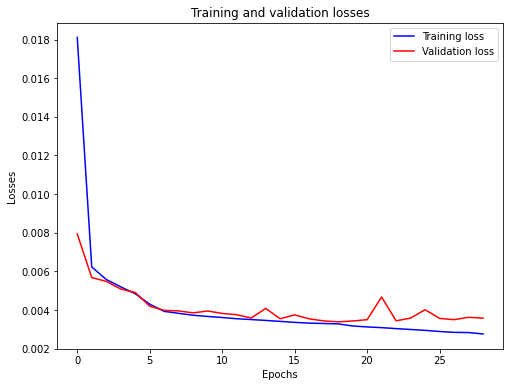

In [47]:
# FULL DATA 
plot_train_history(FULL_LSTMIMO)

In [49]:
FD_predictions = FULL_LSTMIMO.predict(test_longer_inputs['X'])
FD_eval_df = create_evaluation_df(FD_predictions, test_longer_inputs, HORIZON, y_scaler)
performance['LSTM-MIMO-full-data'] = FULL_LSTMIMO.evaluate(test_longer_inputs['X'],test_longer_inputs['target'], verbose=0)
mape_performance['LSTM-MIMO-full-data'] = mape(FD_eval_df['prediction'], FD_eval_df['actual'])

In [50]:
MAX_EPOCHS = 50
BATCHSIZE = 10
patience = 10

LSTMIMO = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, input_shape=(24, 6)),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(HORIZON)
])

In [51]:
LSTMIMO.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

In [52]:
LSTMIMO.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                792       
Total params: 5,784
Trainable params: 5,784
Non-trainable params: 0
_________________________________________________________________


In [114]:
mape_performance['LSTM-MIMO'] = []
mse_performance['LSTM-MIMO'] = []
for i in range(1,11):
    LSTMIMO.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    history = LSTMIMO.fit(train_inputs['X'], train_inputs['target'], batch_size=32, epochs=MAX_EPOCHS,
                  validation_split=0.15,
                  callbacks=[early_stopping], verbose=1)


    #save_model(LSTMIMO, i)
    predictions = LSTMIMO.predict(test_inputs['X'])
    eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
    mape = validation(eval_df['prediction'], eval_df['actual'], 'MAPE')
    rmse = validation(eval_df['prediction'], eval_df['actual'], 'RMSE')
    mape_performance['LSTM-MIMO'].append(mape)
    mse_performance['LSTM-MIMO'].append(rmse)
    print('RUN '+str(i)+'\n')
    metrics.loc[i] = pd.Series({'mape':mape, 'rmse':rmse})

    file1 = open('./results/ERCOT_LSTM_MIMO.txt', 'a') 
    file1.write('\nRUN '+str(i)+':') 
    file1.writelines(['\n'+str(mape), '\n'+str(rmse)]) 
    file1.close()
metrics.to_csv('./results/ERCOT_MIMO.csv')

Epoch 1/25
690/690 [==============================] - 10s 15ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 2/25
690/690 [==============================] - 10s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 3/25
690/690 [==============================] - 10s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 4/25
690/690 [==============================] - 10s 15ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 5/25
690/690 [==============================] - 10s 15ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 6/25
690/690 [==============================] - 10s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 7/25
690/6

Epoch 6/25
690/690 [==============================] - 11s 16ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 7/25
690/690 [==============================] - 11s 16ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 8/25
690/690 [==============================] - 11s 16ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 9/25
690/690 [==============================] - 10s 15ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 10/25
690/690 [==============================] - 10s 14ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 11/25
690/690 [==============================] - 11s 15ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 12/25
69

In [53]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history = LSTMIMO.fit(train_inputs['X'], train_inputs['target'], batch_size=32, epochs=MAX_EPOCHS,
                  validation_split=0.15,
                  callbacks=[early_stopping], verbose=1)

Epoch 1/50
694/694 [==============================] - 10s 15ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 2/50
694/694 [==============================] - 10s 14ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 3/50
694/694 [==============================] - 10s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 4/50
694/694 [==============================] - 10s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 5/50
694/694 [==============================] - 10s 15ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 6/50
694/694 [==============================] - 11s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 7/50
694/6

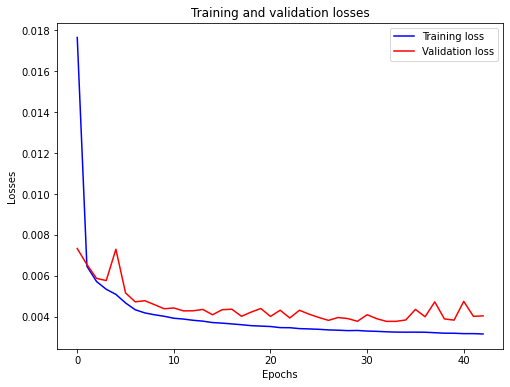

In [55]:
plot_train_history(LSTMIMO)

In [57]:
predictions = LSTMIMO.predict(test_inputs['X'])
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
performance['LSTM-MIMO'] = LSTMIMO.evaluate(test_inputs['X'],test_inputs['target'], verbose=0)
mape_performance['LSTM-MIMO'] = mape(eval_df['prediction'], eval_df['actual'])

[]

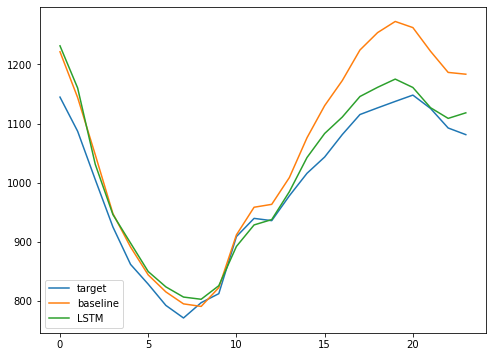

In [1181]:
import random
i = random.randint(1,8740)
plt.plot(y_scaler.inverse_transform(test_inputs.dataframe.loc[:,'target'])[i].reshape(24,-1), label='target')
plt.plot(y_scaler.inverse_transform(predictions_B.reshape(-1,24))[i], label='baseline')
plt.plot(y_scaler.inverse_transform(predictions.reshape(-1,24))[i], label='LSTM')
plt.legend()
[]

In [90]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
df = eval_df.groupby('h')['APE'].mean()
df.reindex(['t+1', 't+2', 't+3', 't+4', 't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23', 't+24'])

h
t+1     0.021260
t+2     0.028931
t+3     0.035425
t+4     0.041277
t+5     0.046222
t+6     0.050896
t+7     0.054871
t+8     0.058713
t+9     0.061704
t+10    0.062074
t+11    0.062840
t+12    0.063808
t+13    0.064861
t+14    0.066111
t+15    0.067169
t+16    0.066280
t+17    0.067063
t+18    0.066291
t+19    0.066471
t+20    0.067548
t+21    0.067307
t+22    0.068315
t+23    0.066865
t+24    0.067168
Name: APE, dtype: float64

In [116]:
MAX_EPOCHS = 50
BATCHSIZE = 32
patience = 10

ConditionalRNN = Sequential(layers=[ConditionalRNN(32, cell='LSTM'),
                                    Dense(HORIZON)])

In [117]:
ConditionalRNN.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

In [60]:
ConditionalRNN.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [118]:
mape_performance['ConditionalRNN'] = []
mse_performance['ConditionalRNN'] = []
for i in range(1,11):
    ConditionalRNN.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    history = ConditionalRNN.fit([train_inputs['X'],train_c1,train_c2], train_inputs['target'], batch_size=32, epochs=MAX_EPOCHS,
                  validation_split=0.15,
                  callbacks=[early_stopping], verbose=1)


    #save_model(ConditionalRNN, i)
    predictions = ConditionalRNN.predict([test_inputs['X'],test_c1,test_c2])
    eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
    mape = validation(eval_df['prediction'], eval_df['actual'], 'MAPE')
    rmse = validation(eval_df['prediction'], eval_df['actual'], 'RMSE')
    mape_performance['ConditionalRNN'].append(mape)
    mse_performance['ConditionalRNN'].append(rmse)
    print('RUN '+str(i)+'\n')
    metrics.loc[i] = pd.Series({'mape':mape, 'rmse':rmse})

    file1 = open('./results/ERCOT_ConditionalRNN.txt', 'a') 
    file1.write('\nRUN '+str(i)+':') 
    file1.writelines(['\n'+str(mape), '\n'+str(rmse)]) 
    file1.close()
metrics.to_csv('./results/ERCOT_ConditionalRNN.csv')

Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
689/690 [============================>.] - ETA: 0s - loss: 0.0189 - mean_squared_error: 0.0189WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'tuple'> input: (<tf.Tensor 'IteratorGetNext:0' shape=(None, 24, 6) dtype=float64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 8) dtype=float64>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 2) dtype=float64>)
Consider rewriting this model with the Functional API.
690/690 [==============================] - 13s 19ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 2/50
690/690 [==============================] - 13s 18ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 3/50
690/690 [==============================] - 12s 18ms/step - loss: 0.0060 - mean_s

690/690 [==============================] - 13s 18ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 44/50
690/690 [==============================] - 12s 18ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 45/50
690/690 [==============================] - 13s 18ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 46/50
690/690 [==============================] - 12s 18ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 47/50
690/690 [==============================] - 12s 18ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 48/50
690/690 [==============================] - 12s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 49/50
690/690 [=

690/690 [==============================] - 11s 16ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 4/50
690/690 [==============================] - 11s 17ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 5/50
690/690 [==============================] - 11s 16ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/50
690/690 [==============================] - 12s 17ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 7/50
690/690 [==============================] - 11s 16ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 8/50
690/690 [==============================] - 12s 17ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 9/50
690/690 [=======

690/690 [==============================] - 11s 16ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/50
690/690 [==============================] - 11s 16ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 4/50
690/690 [==============================] - 11s 16ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 5/50
690/690 [==============================] - 11s 16ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 6/50
690/690 [==============================] - 12s 18ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 7/50
690/690 [==============================] - 12s 18ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 8/50
690/690 [=======

690/690 [==============================] - 11s 16ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 5/50
690/690 [==============================] - 12s 17ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 6/50
690/690 [==============================] - 12s 17ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 7/50
690/690 [==============================] - 12s 17ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 8/50
690/690 [==============================] - 12s 17ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 9/50
690/690 [==============================] - 12s 18ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 10/50
690/690 [======

690/690 [==============================] - 12s 18ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 11/50
690/690 [==============================] - 12s 17ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 12/50
690/690 [==============================] - 12s 18ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 13/50
690/690 [==============================] - 12s 17ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 14/50
690/690 [==============================] - 11s 16ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 15/50
690/690 [==============================] - 11s 16ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 16/50
690/690 [=

In [61]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
tf.keras.backend.set_floatx('float64')
history = ConditionalRNN.fit([train_inputs['X'],train_c1,train_c2], train_inputs['target'], batch_size=32, epochs=MAX_EPOCHS,
                  validation_split=0.15,
                  callbacks=[early_stopping], verbose=1)

Epoch 1/50
Consider rewriting this model with the Functional API.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passi

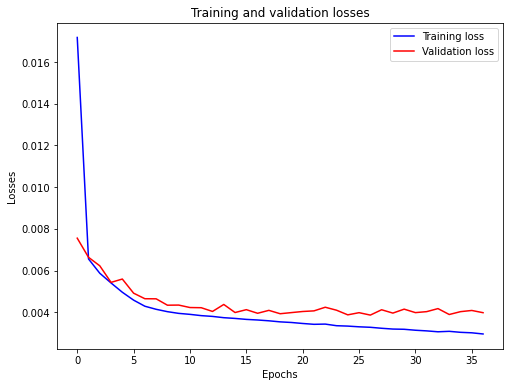

In [62]:
plot_train_history(ConditionalRNN)

In [63]:
performance['ConditionalRNN'] = ConditionalRNN.evaluate([test_inputs['X'],test_c1,test_c2],test_inputs['target'], verbose=0)

In [64]:
cpredictions = ConditionalRNN.predict([test_inputs['X'],test_c1,test_c2])
ceval_df = create_evaluation_df(cpredictions, test_inputs, HORIZON, y_scaler)
mape_performance['ConditionalRNN'] = mape(ceval_df['prediction'], ceval_df['actual'])

Consider rewriting this model with the Functional API.


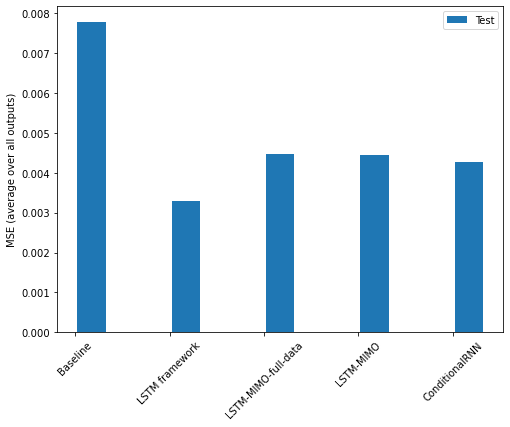

In [65]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_squared_error'
metric_index = LSTMIMO.metrics_names.index('mean_squared_error')
#val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

#plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MSE (average over all outputs)')
_ = plt.legend()

In [302]:
del mape_performance['Reference']

In [66]:
mape_performance['Reference'] = 0.0559

[6.743083255234751, 4.701520647896263, 4.7548216747990795, 4.677669521818806, 4.552798989880857, 5.59]


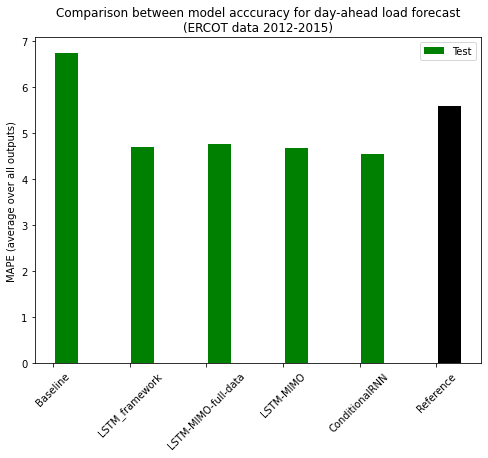

In [67]:
x = np.arange(len(mape_performance))
width = 0.3

metric_name = 'mean_average_percentage_error'
#metric_index = LSTMIMO.metrics_names.index('mean_squared_error')
#val_mae = [v[metric_index] for v in val_performance.values()]
test_mape = []
for i in mape_performance.values():
    test_mape.append(100*i)
#test_mape = mape_performance.values()
print(test_mape)

#plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mape, width, label='Test', color=['green','green','green','green','green','black'])
plt.xticks(ticks=x, labels=mape_performance.keys(),
           rotation=45)
plt.title('Comparison between model acccuracy for day-ahead load forecast\n(ERCOT data 2012-2015)')
plt.ylabel('MAPE (average over all outputs)')
_ = plt.legend()

In [428]:
df2 = df.merge(series_to_supervised(df), how='right', left_index=True, right_index=True)

In [46]:
w2 = WindowGenerator(input_width=24, label_width=24, shift=24, train_df=train_df_short, test_df=test_df_short,
                     label_columns=['value'])
w2

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['value']

In [51]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

In [374]:
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 48, 14)
Inputs shape: (3, 24, 14)
labels shape: (3, 24, 1)


In [375]:
w2.train.element_spec

(TensorSpec(shape=(None, 24, 14), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

In [376]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 24, 14)
Labels shape (batch, time, features): (32, 24, 1)


In [58]:
def validation(forecasted, real, parameter):
    ''' 
    compute some important parameters to compare forecasting results
    '''
    value = 0
    value_1 = 0
    value_2 = 0

    if parameter == 'SMAPE':
        for i in range(len(forecasted)):
            if real[i] + forecasted[i] == 0:
                value += 0
            else: 
                value += ((abs(real[i] - forecasted[i])) / (real[i] + forecasted[i])) * 100
        final_value = value / len(forecasted)  

    elif parameter == 'MAPE':
        for i in range(len(forecasted)):
            if real[i] == 0:
                value += 0
            else: 
                value += (abs(real[i] - forecasted[i]))/real[i]
        final_value = value / len(forecasted) * 100

    elif parameter == 'RMSE':
        for i in range(len(forecasted)):
            value += (real[i] - forecasted[i]) ** 2
        final_value = (value / len(forecasted)) ** (1 / 2) 

    elif parameter == 'R':
        for i in range(len(forecasted)):
            value += (real[i] - np.mean(real)) * (forecasted[i] - np.mean(forecasted))
            value_1 += (real[i] - np.mean(real)) ** 2
            value_2 += (forecasted[i] - np.mean(forecasted)) ** 2

        if value_1 == 0 or value_2 == 0:
            final_value = 100
        else:
            final_value = (value / ((value_1 ** (1 / 2)) * (value_2 ** (1 / 2))))*100

    return final_value

In [221]:
def MAPE(model, window):
    actual = []
    forecasted = []
    for inputs, labels in window.test:
        yhat = y[0] in model.predict(inputs)
        print(yhat.shape)
        print(labels.shape)
        labels = scaler.inverse_transform(np.array(labels).reshape(-1,1))
        yhat = model.predict(inputs)
        yhat = scaler.inverse_transform(yhat.reshape(-1,1))
        actual.append(labels)
        forecasted.append(yhat)
    actual = itertools.chain(*actual)
    forecasted = itertools.chain(*forecasted)
    mape = validation(list(actual), list(forecasted), 'MAPE')
    print('MAPE: %f %%' % mape)
    return(mape)

In [316]:
plot_col = 'value'
label_col_index = w2.label_columns_indices.get(plot_col, None)
inputs = np.concatenate([x for x, y in w2.test], axis=0)
labels = np.concatenate([y for x, y in w2.test], axis=0)
yhat = lstm_model(inputs)[:,:,label_col_index]
#yhat = scaler.inverse_transform()
yhat = tf.reshape(yhat, [-1,24,1])
print(yhat.shape)
print(inputs.shape)
print(labels.shape)
#print(np.concatenate((inputs[:,:,1:],yhat),axis=2).shape)
inv_yhat = np.concatenate((yhat,inputs[:,:,1:]),axis=2)
inv_yhat = scaler.inverse_transform(inv_yhat.reshape(-1,14))
pred = [i[0] for i in inv_yhat]
inv_y = np.concatenate((labels,inputs[:,:,1:]),axis=2)
inv_y = scaler.inverse_transform(inv_y.reshape(-1,14))
act = [i[0] for i in inv_y]
print(pred[:5])
print(act[:5])
mape = validation(pred, act, 'MAPE')
print('MAPE: %f %%' % mape)

(8713, 24, 1)
(8713, 24, 14)
(8713, 24, 1)
[853.853, 820.3377, 802.64703, 793.2433, 805.04376]
[815.1598, 859.4295, 864.9292, 881.81396, 895.4568]
MAPE: 25.572377 %


In [107]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=50):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [250]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, w2)

#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( w2.val)
performance['LSTM'] = lstm_model.evaluate( w2.test, verbose=0)
mape_performance['LSTM'] = MAPE(lstm_model, w2)

print()

Epoch 1/10
698/698 [==============================] - 12s 17ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 2/10
698/698 [==============================] - 12s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 3/10
698/698 [==============================] - 11s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 4/10
698/698 [==============================] - 12s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 5/10
698/698 [==============================] - 11s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 6/10
698/698 [==============================] - 11s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 7/10
698/6

NameError: name 'y' is not defined

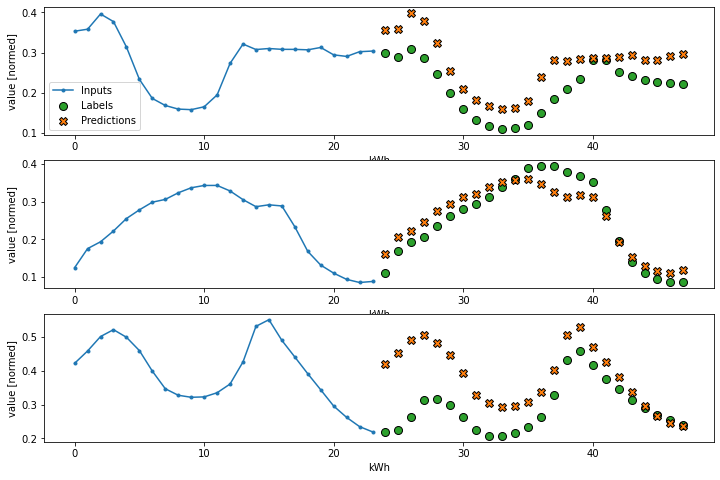

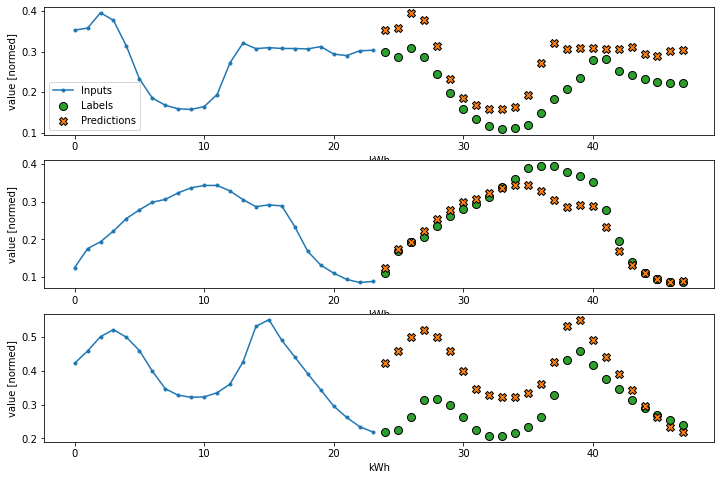

In [194]:
w2.plot(lstm_model)
w2.plot(baseline)

In [11]:
def gradient_importance(seq, model):    
    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)    
    
    with tf.GradientTape() as tape:
        predictions = model(seq)    
    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

In [ ]:
cols = df.columns
#datach = deep_learner.normalize(datach)
#df = df.iloc[:,1:]
df.shape

In [ ]:
#features = cols[1:]
features = cols
importances = gradient_importance(np.array(df[:1000]), lstm_model)
indices = np.argsort(importances)
print(len(features))
print(len(importances))

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model2, w2)

#IPython.display.clear_output()
val_performance['LSTM 2 layer'] = lstm_model.evaluate( w2.val)
performance['LSTM 2 layer'] = lstm_model.evaluate( w2.test, verbose=0)

print()


In [ ]:
w2.plot(residual_lstm)

In [ ]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, w2)

#IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(w2.val)
performance['Residual LSTM'] = residual_lstm.evaluate(w2.test, verbose=0)
print()


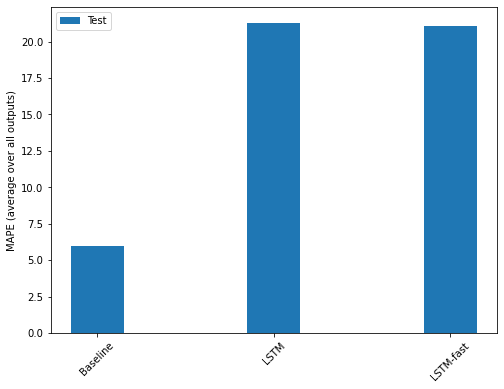

In [188]:
x = np.arange(len(mape_performance))
width = 0.3

metric_name = 'mean_average_performance_error'
#metric_index = lstm_model.metrics_names.index('mape')
test_mape = mape_performance.values()

plt.bar(x, list(itertools.chain(*test_mape)), width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAPE (average over all outputs)')
_ = plt.legend()

In [166]:
list(itertools.chain(*test_mape))

[23.450996430740464]